# Import packages

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

# Load data

In [3]:
data_file_name = 'dataset.xlsx'
data_dir_path = '.'
data_file_path = os.path.join(data_dir_path, data_file_name)

# Load 'data' spreadsheet
df = pd.read_excel(open(data_file_path, 'rb'), sheetname='data', header=1)

# print(df.head())
# print(df.columns)

# 1) Preprocessing - fill in missing values

# Defin a function

In [4]:
def fill_in_missing_data(data, window_size):
    num_of_data = len(data)
    indices = np.where(np.isnan(data))[0]

    for i in indices:
        values = []
        distances = []
        for j in range(1,window_size+1):
            if i-j >= 0 and not np.isnan(data[i-j]):
                values.append(data[i-j])
                distances.append(j)
            if i+j < num_of_data and not np.isnan(data[i+j]):
                values.append(data[i+j])
                distances.append(j)

        values = np.array(values)
        distances = np.array(distances)
        inverse_distances = 1.0 / distances
        weights = inverse_distances / np.sum(inverse_distances)
        filling_value = np.sum(np.multiply(values, weights))
        data[i] = filling_value
    return data

def test_fill_in_missing_data(data, window_size):
    modified_data = fill_in_missing_data(np.copy(data), 3)
    plt.plot(modified_data)
    plt.show()
#     data[np.where(np.isnan(data))] = 0
#     plt.plot(data)
#     plt.ylim(1800, 2100)
#     plt.show()
    

# Fill in missing values - Kospi & Kosdaq

In [5]:
kospi = df['KOSPI']
kosdaq = df['KOSDAQ']

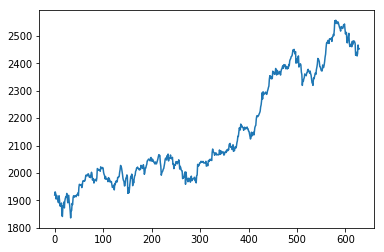

In [6]:
test_fill_in_missing_data(np.copy(kospi),3)

In [7]:
# fill in missing values
window_size = 3
df['KOSPI'] = fill_in_missing_data(np.copy(kospi), window_size)
df['KOSDAQ'] = fill_in_missing_data(np.copy(kosdaq), window_size)

# 2) Preprocessing - add 'season' feature based on 'date'

In [8]:
season_as_num = df['Date'].apply(lambda dt: (dt.month%12 + 3)//3)
df['Season'] = np.where(season_as_num == 1, 'winter', 
                            (np.where(season_as_num == 2, 'spring',
                                     np.where(season_as_num == 3, 'summer', 'fall'))))

# 3) Preprocessing - add 'Average_Temperature_Normalized'

In [9]:
df['Average_Temperature_Normalized'] = np.zeros_like(df['Average_Temperature'])

In [10]:
month = 0
season = None
indices = []
avg_temperatures = []
for i, date in enumerate(df['Date']):
    if month == 0:
        month = date.month
        season = df['Season'][i]
    indices.append(i)
    avg_temperatures.append(df['Average_Temperature'][i])
    if i == len(df['Date'])-1:
        mean_avg_temperature = np.mean(avg_temperatures)
        sd_avg_temperature = np.std(avg_temperatures)
        if season == 'spring' or season == 'summer':
            df['Average_Temperature_Normalized'][indices] = (mean_avg_temperature - df['Average_Temperature'][indices]) / sd_avg_temperature
        else:
            df['Average_Temperature_Normalized'][indices] = (df['Average_Temperature'][indices] - mean_avg_temperature) / sd_avg_temperature
    elif month != date.month:
        mean_avg_temperature = np.mean(avg_temperatures[:-1])
        sd_avg_temperature = np.std(avg_temperatures[:-1])
        if season == 'spring' or season == 'summer':
            df['Average_Temperature_Normalized'][indices] = (mean_avg_temperature - df['Average_Temperature'][indices]) / sd_avg_temperature
        else:
            df['Average_Temperature_Normalized'][indices] = (df['Average_Temperature'][indices] - mean_avg_temperature) / sd_avg_temperature
        month = date.month
        indices = [i]
        avg_temperatures = [df['Average_Temperature'][i]]
    

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


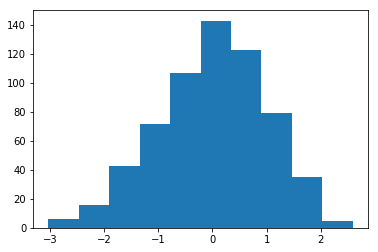

In [11]:
plt.hist(df['Average_Temperature_Normalized'])
plt.show()

# 4) Preprocessing - classify 'Revenue' for classification

# Add 'Revenue_Normalized' variable to see how 'Revenue' has changed

In [12]:
df['Revenue_Normalized'] = np.zeros_like(df['Revenue'])

In [13]:
month = 0
indices = []
revenues = []
for i, date in enumerate(df['Date']):
    if month == 0:
        month = date.month
    indices.append(i)
    revenues.append(df['Revenue'][i])
    if i == len(df['Date'])-1:
        mean_revenue = np.mean(revenues)
        sd_revenue = np.std(revenues)
        df['Revenue_Normalized'][indices] = (df['Revenue'][indices] - mean_revenue) / sd_revenue
    elif month != date.month:
        mean_revenue = np.mean(revenues[:-1])
        sd_revenue = np.std(revenues[:-1])
        df['Revenue_Normalized'][indices] = (df['Revenue'][indices] - mean_revenue) / sd_revenue
        month = date.month
        indices = [i]
        revenues = [df['Revenue'][i]]
    

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


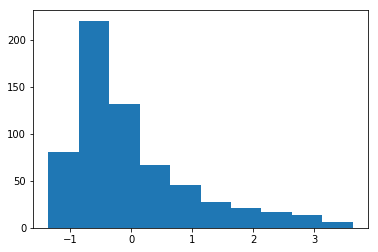

In [14]:
plt.hist(df['Revenue_Normalized'])
plt.show()

# Classify 'Revenue'

In [17]:
rate = df['Revenue_Normalized']
df['Rate_Class'] = np.where(rate > 0.7, 'very high', 
                            (np.where(rate > 0.3, 'high',
                                     np.where(rate > -0.3, 'moderate',
                                             np.where(rate > -0.7, 'low', 'very low')))))

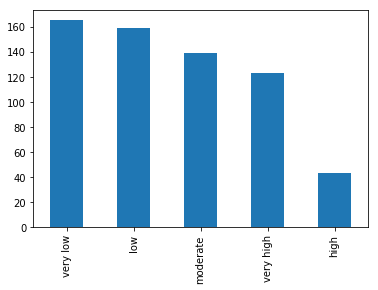

In [18]:
# Show the distribution of 'Rate Class'
df['Rate_Class'].value_counts().plot(kind='bar')
plt.show()

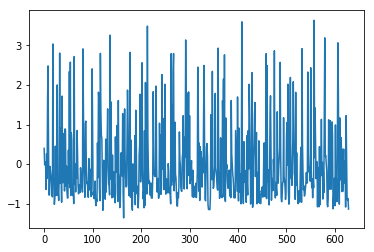

In [19]:
plt.plot(rate.tolist())
plt.show()

# 5) Preprocessing - Normalization

# Define a function

In [20]:
def normalize(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.mean(data)
    denominator = np.std(data)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

# All Variables except 'Date', 'Rate_Class', 'Season' and normalized variables

In [21]:
df.columns

Index([                          u'Date',                          u'KOSPI',
                               u'KOSDAQ',            u'Average_Temperature',
                   u'Lowest_Temperature',            u'Highest_temperature',
                        u'Precipitation',             u'Average_Wind_Speed',
            u'Average_Relative_humidity',                 u'Daylight_Hours',
                          u'Cloud_Cover',                u'Duration_of_Fog',
                              u'Revenue',                        u'Fitness',
                        u'Sports_Center',                            u'Gym',
                                 u'Diet',                           u'Body',
                  u'Busan_Sports_Center',                      u'Busan_Gym',
                               u'Season', u'Average_Temperature_Normalized',
                   u'Revenue_Normalized',                     u'Rate_Class'],
      dtype='object')

In [22]:
columns = [x for x in df.columns if x not in ['Date', 'Rate_Class', 'Season', 'Average_Temperature_Normalized', 'Revenue_Normalized']]
print(columns)
df_scaled = df.copy()
df_scaled[columns] = df_scaled[columns].apply(normalize, axis=0)
df_scaled['Date'] = df['Date']
df_scaled['Rate_Class'] = df['Rate_Class']

[u'KOSPI', u'KOSDAQ', u'Average_Temperature', u'Lowest_Temperature', u'Highest_temperature', u'Precipitation', u'Average_Wind_Speed', u'Average_Relative_humidity', u'Daylight_Hours', u'Cloud_Cover', u'Duration_of_Fog', u'Revenue', u'Fitness', u'Sports_Center', u'Gym', u'Diet', u'Body', u'Busan_Sports_Center', u'Busan_Gym']


# Final dataset - Done with preprocessing

In [24]:
df_scaled.head()

,Date,KOSPI,KOSDAQ,Average_Temperature,Lowest_Temperature,Highest_temperature,Precipitation,Average_Wind_Speed,Average_Relative_humidity,Daylight_Hours,...,Sports_Center,Gym,Diet,Body,Busan_Sports_Center,Busan_Gym,Season,Average_Temperature_Normalized,Revenue_Normalized,Rate_Class
0,2016-01-04,-1.151953,0.287214,-0.608890,-0.506602,-0.574746,-0.285686,-0.016943,0.342568,-0.836233,...,0.903352,3.990658,2.044022,1.343423,2.862245,4.261320,winter,2.591066,0.399221,high
1,2016-01-05,-1.092558,0.436134,-1.216455,-0.994161,-1.469336,-0.267387,0.016230,0.183380,-1.126611,...,0.360811,2.008003,1.305837,0.905758,-0.567634,2.863554,winter,0.857798,-0.017328,moderate
2,2016-01-06,-1.118294,0.512017,-1.276020,-1.149293,-1.242539,-0.285686,-0.000357,-0.005287,-0.866621,...,-0.026693,1.459698,1.545523,0.853020,-0.274840,2.475287,winter,0.687870,0.052096,moderate
3,2016-01-07,-1.224771,0.331558,-1.383237,-1.226859,-1.418937,-0.285686,-0.016943,0.372047,-0.836233,...,0.070194,0.846762,1.643549,1.723091,-0.442151,2.785901,winter,0.381999,-0.045098,moderate
4,2016-01-08,-1.157706,0.400327,-1.550020,-1.404153,-1.620535,-0.285686,-0.000357,0.277713,-0.819350,...,-0.220422,0.083722,1.214685,1.021763,-0.818601,0.689253,winter,-0.093800,-0.642152,low


# Save the data in excel format

In [25]:
import openpyxl

In [26]:
df_scaled.to_excel('df_scaled.xlsx', sheet_name='sheet1', index=False)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/io/excel.py:784: DeprecationWarning: Call to deprecated function remove_sheet (Use wb.remove(worksheet) or del wb[sheetname]).
  self.book.remove_sheet(self.book.worksheets[0])
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 16:33:57.498948. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Regression Models

# 1) Linear Model

# Import additional packages 

In [54]:
from sklearn.linear_model import LinearRegression

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:14:37.660146. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Determin which features are used

In [55]:
# Refer to the list of columns of df_scaled to decide which features you want to use for lstm model
print(df_scaled.columns.tolist())
linear_variables = ['Average_Temperature_Normalized', 'Revenue_Normalized']

[u'Date', u'KOSPI', u'KOSDAQ', u'Average_Temperature', u'Lowest_Temperature', u'Highest_temperature', u'Precipitation', u'Average_Wind_Speed', u'Average_Relative_humidity', u'Daylight_Hours', u'Cloud_Cover', u'Duration_of_Fog', u'Revenue', u'Fitness', u'Sports_Center', u'Gym', u'Diet', u'Body', u'Busan_Sports_Center', u'Busan_Gym', 'Season', 'Average_Temperature_Normalized', 'Revenue_Normalized', 'Rate_Class']


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:14:39.296090. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Assign hyperparameters 

In [56]:
# Hyperparameters for Linear model. Tune these variables.


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:14:41.085813. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create dataset

In [57]:
# Create dataset
dataX = []
dataY = []
for i in range(df_scaled.shape[0] - seq_len):
    _x = df_scaled.loc[i:i+seq_len-1, lstm_variables].values
    _y = [df_scaled.loc[i+seq_len, 'Revenue_Normalized']]
    print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

(array([[ 2.59106621,  0.39922085],
       [ 0.85779789, -0.01732845],
       [ 0.68786962,  0.05209643],
       [ 0.38199874, -0.0450984 ],
       [-0.0938004 , -0.6421524 ]]), '->', [0.2603710823693933])
(array([[ 0.85779789, -0.01732845],
       [ 0.68786962,  0.05209643],
       [ 0.38199874, -0.0450984 ],
       [-0.0938004 , -0.6421524 ],
       [ 0.34801309,  0.26037108]]), '->', [-0.36445286742917216])
(array([[ 0.68786962,  0.05209643],
       [ 0.38199874, -0.0450984 ],
       [-0.0938004 , -0.6421524 ],
       [ 0.34801309,  0.26037108],
       [ 0.58591266, -0.36445287]]), '->', [1.6488687485884277])
(array([[ 0.38199874, -0.0450984 ],
       [-0.0938004 , -0.6421524 ],
       [ 0.34801309,  0.26037108],
       [ 0.58591266, -0.36445287],
       [-0.0938004 ,  1.64886875]]), '->', [2.481967348319848])
(array([[-0.0938004 , -0.6421524 ],
       [ 0.34801309,  0.26037108],
       [ 0.58591266, -0.36445287],
       [-0.0938004 ,  1.64886875],
       [-0.43365694,  2.48196735]]

       [ 1.73409699, -0.09226871]]), '->', [-0.2927375770843674])
(array([[ 0.40085767, -0.55408958],
       [ 0.86594115, -0.51993562],
       [ 1.33102464, -0.71535564],
       [ 1.73409699, -0.09226871],
       [ 1.42404133, -0.29273758]]), '->', [-0.31946675909286787])
(array([[ 0.86594115, -0.51993562],
       [ 1.33102464, -0.71535564],
       [ 1.73409699, -0.09226871],
       [ 1.42404133, -0.29273758],
       [ 1.14499124, -0.31946676]]), '->', [-0.5724764283868637])
(array([[ 1.33102464, -0.71535564],
       [ 1.73409699, -0.09226871],
       [ 1.42404133, -0.29273758],
       [ 1.14499124, -0.31946676],
       [-1.7754925 , -0.57247643]]), '->', [-0.7062030055075712])
(array([[ 1.73409699, -0.09226871],
       [ 1.42404133, -0.29273758],
       [ 1.14499124, -0.31946676],
       [-1.7754925 , -0.57247643],
       [-0.56922825, -0.70620301]]), '->', [2.9124629355597227])
(array([[ 1.42404133, -0.29273758],
       [ 1.14499124, -0.31946676],
       [-1.7754925 , -0.57247643],


(array([[ 0.13377475, -0.8528712 ],
       [ 1.10441947,  0.22805643],
       [ 0.53821005, -0.83646426],
       [ 0.13377475, -0.1888728 ],
       [ 1.34708064, -0.2303727 ]]), '->', [-0.5392091637825079])
(array([[ 1.10441947,  0.22805643],
       [ 0.53821005, -0.83646426],
       [ 0.13377475, -0.1888728 ],
       [ 1.34708064, -0.2303727 ],
       [ 1.34708064, -0.53920916]]), '->', [-0.9773708970154749])
(array([[ 0.53821005, -0.83646426],
       [ 0.13377475, -0.1888728 ],
       [ 1.34708064, -0.2303727 ],
       [ 1.34708064, -0.53920916],
       [ 0.13377475, -0.9773709 ]]), '->', [0.6874506664798289])
(array([[ 0.13377475, -0.1888728 ],
       [ 1.34708064, -0.2303727 ],
       [ 1.34708064, -0.53920916],
       [ 0.13377475, -0.9773709 ],
       [ 1.34708064,  0.68745067]]), '->', [-0.19273325578551428])
(array([[ 1.34708064, -0.2303727 ],
       [ 1.34708064, -0.53920916],
       [ 0.13377475, -0.9773709 ],
       [ 1.34708064,  0.68745067],
       [ 0.13377475, -0.1927332

       [-0.87974044,  0.56899011]]), '->', [-0.24513723269246263])
(array([[-1.06608058, -0.85972356],
       [-0.64681528, -0.35231926],
       [-1.06608058,  1.83008932],
       [-0.87974044,  0.56899011],
       [-0.78657038, -0.24513723]]), '->', [-0.3101305917010373])
(array([[-0.64681528, -0.35231926],
       [-1.06608058,  1.83008932],
       [-0.87974044,  0.56899011],
       [-0.78657038, -0.24513723],
       [-0.92632548, -0.31013059]]), '->', [-0.15163801446960087])
(array([[-1.06608058,  1.83008932],
       [-0.87974044,  0.56899011],
       [-0.78657038, -0.24513723],
       [-0.92632548, -0.31013059],
       [-0.46047514, -0.15163801]]), '->', [-0.3146915291753232])
(array([[-0.87974044,  0.56899011],
       [-0.78657038, -0.24513723],
       [-0.92632548, -0.31013059],
       [-0.46047514, -0.15163801],
       [-0.08779487, -0.31469153]]), '->', [1.9726186141790756])
(array([[-0.78657038, -0.24513723],
       [-0.92632548, -0.31013059],
       [-0.46047514, -0.15163801],

       [ 1.85917696, -0.15553919]]), '->', [-0.8390155243612153])
(array([[ 0.37139457,  0.08902742],
       [ 1.02601882, -0.50492006],
       [ 1.53186483, -0.82373011],
       [ 1.85917696, -0.15553919],
       [ 1.38308659, -0.83901552]]), '->', [-0.8018938064762894])
(array([[ 1.02601882, -0.50492006],
       [ 1.53186483, -0.82373011],
       [ 1.85917696, -0.15553919],
       [ 1.38308659, -0.83901552],
       [-0.75932005, -0.80189381]]), '->', [-0.8215464806506619])
(array([[ 1.53186483, -0.82373011],
       [ 1.85917696, -0.15553919],
       [ 1.38308659, -0.83901552],
       [-0.75932005, -0.80189381],
       [-0.84858699, -0.82154648]]), '->', [-0.5551435640647234])
(array([[ 1.85917696, -0.15553919],
       [ 1.38308659, -0.83901552],
       [-0.75932005, -0.80189381],
       [-0.84858699, -0.82154648],
       [ 0.46066151, -0.55514356]]), '->', [-0.8215464806506619])
(array([[ 1.38308659, -0.83901552],
       [-0.75932005, -0.80189381],
       [-0.84858699, -0.82154648],


(array([[ 0.18680723, -0.84850514],
       [ 1.30269112,  1.60896853],
       [ 0.54389007,  0.27087563],
       [ 0.18680723,  0.02133118],
       [-0.79517059, -0.24552798]]), '->', [-0.36703471294731654])
(array([[ 1.30269112,  1.60896853],
       [ 0.54389007,  0.27087563],
       [ 0.18680723,  0.02133118],
       [-0.79517059, -0.24552798],
       [-0.66126453, -0.36703471]]), '->', [-0.6328306911035645])
(array([[ 0.54389007,  0.27087563],
       [ 0.18680723,  0.02133118],
       [-0.79517059, -0.24552798],
       [-0.66126453, -0.36703471],
       [ 0.27607794, -0.63283069]]), '->', [-0.853061644433027])
(array([[ 0.18680723,  0.02133118],
       [-0.79517059, -0.24552798],
       [-0.66126453, -0.36703471],
       [ 0.27607794, -0.63283069],
       [ 0.14217187, -0.85306164]]), '->', [-0.6738392134476713])
(array([[-0.79517059, -0.24552798],
       [-0.66126453, -0.36703471],
       [ 0.27607794, -0.63283069],
       [ 0.14217187, -0.85306164],
       [ 1.70440932, -0.6738392

       [ 1.0098979 , -0.91212639]]), '->', [-0.35782897399402025])
(array([[ 0.42116818,  1.13783456],
       [ 0.71553304,  1.72595352],
       [ 1.24538978,  0.26223254],
       [ 1.0098979 , -0.91212639],
       [ 0.89215195, -0.35782897]]), '->', [-0.42171410002114673])
(array([[ 0.71553304,  1.72595352],
       [ 1.24538978,  0.26223254],
       [ 1.0098979 , -0.91212639],
       [ 0.89215195, -0.35782897],
       [ 0.89215195, -0.4217141 ]]), '->', [-0.6689871172320244])
(array([[ 1.24538978,  0.26223254],
       [ 1.0098979 , -0.91212639],
       [ 0.89215195, -0.35782897],
       [ 0.89215195, -0.4217141 ],
       [ 1.36313573, -0.66898712]]), '->', [0.11943049691451273])
(array([[ 1.0098979 , -0.91212639],
       [ 0.89215195, -0.35782897],
       [ 0.89215195, -0.4217141 ],
       [ 1.36313573, -0.66898712],
       [ 0.36229521,  0.1194305 ]]), '->', [-0.13423103289907765])
(array([[ 0.89215195, -0.35782897],
       [ 0.89215195, -0.4217141 ],
       [ 1.36313573, -0.66898712

(array([[-0.21085103, -0.07366327],
       [-0.28493382, -0.23169594],
       [ 1.04855646, -0.4299299 ],
       [ 0.52997691,  2.43545191],
       [-1.54434131, -0.09168454]]), '->', [-0.5948938267891185])
(array([[-0.28493382, -0.23169594],
       [ 1.04855646, -0.4299299 ],
       [ 0.52997691,  2.43545191],
       [-1.54434131, -0.09168454],
       [-0.95167896, -0.59489383]]), '->', [-0.41468113458405464])
(array([[ 1.04855646, -0.4299299 ],
       [ 0.52997691,  2.43545191],
       [-1.54434131, -0.09168454],
       [-0.95167896, -0.59489383],
       [-3.02599719, -0.41468113]]), '->', [-0.849964098833209])
(array([[ 0.52997691,  2.43545191],
       [-1.54434131, -0.09168454],
       [-0.95167896, -0.59489383],
       [-3.02599719, -0.41468113],
       [-1.6925069 , -0.8499641 ]]), '->', [-0.3649350822518797])
(array([[-1.54434131, -0.09168454],
       [-0.95167896, -0.59489383],
       [-3.02599719, -0.41468113],
       [-1.6925069 , -0.8499641 ],
       [ 0.23050608, -0.3649350

(array([[-0.1095108 ,  0.37890136],
       [ 0.61295629, -0.69228488],
       [-0.48975664, -0.18419165],
       [-0.22358455,  0.38152039],
       [ 0.1186367 , -0.47752382]]), '->', [0.07561684356263325])
(array([[ 0.61295629, -0.69228488],
       [-0.48975664, -0.18419165],
       [-0.22358455,  0.38152039],
       [ 0.1186367 , -0.47752382],
       [-0.48975664,  0.07561684]]), '->', [-0.11609668334179851])
(array([[-0.48975664, -0.18419165],
       [-0.22358455,  0.38152039],
       [ 0.1186367 , -0.47752382],
       [-0.48975664,  0.07561684],
       [ 0.42283337, -0.11609668]]), '->', [-1.0851404668751286])
(array([[-0.22358455,  0.38152039],
       [ 0.1186367 , -0.47752382],
       [-0.48975664,  0.07561684],
       [ 0.42283337, -0.11609668],
       [ 0.72703004, -1.08514047]]), '->', [1.2248503900881067])
(array([[ 0.1186367 , -0.47752382],
       [-0.48975664,  0.07561684],
       [ 0.42283337, -0.11609668],
       [ 0.72703004, -1.08514047],
       [ 1.82974298,  1.2248503

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:14:55.028876. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create train, validation and test set

In [63]:
train_size = int(len(dataY)*0.6)
val_size = int(len(dataY)*0.25)
test_size = len(dataY) - train_size - val_size

lm_trainX, lm_valX, lm_testX = np.array(dataX[:train_size]).reshape((train_size, -1)),\
                               np.array(dataX[train_size:train_size+val_size]).reshape((val_size, -1)),\
                               np.array(dataX[train_size+val_size:len(dataX)]).reshape((test_size, -1))
lm_trainY, lm_valY, lm_testY = np.array(dataY[:train_size]).reshape((train_size, -1)),\
                               np.array(dataY[train_size:train_size+val_size]).reshape((val_size, -1)),\
                               np.array(dataY[train_size+val_size:len(dataY)]).reshape((test_size, -1))

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:20:50.966253. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create and train Linear model

In [66]:
lm = LinearRegression(fit_intercept=True, normalize=False, copy_X=True)
lm.fit(lm_trainX, lm_trainY)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:21:07.409318. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [72]:
lm_val_pred = lm.predict(lm_valX)
lm_test_pred = lm.predict(lm_testX)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:22:26.190843. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


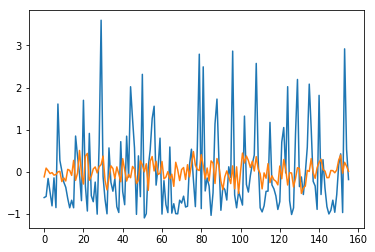

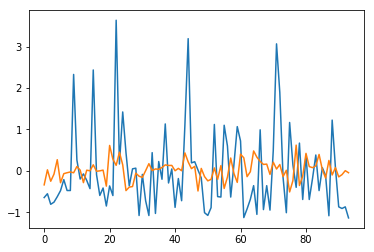

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:23:11.898864. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [74]:
plt.plot(lm_valY)
plt.plot(lm_val_pred)
plt.show()
    
plt.plot(lm_testY)
plt.plot(lm_test_pred)
plt.show()

In [75]:
def rmse(target, pred):
    result = np.sqrt(np.mean(np.square(target - pred)))
    return result

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:23:16.063969. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [77]:
val_rmse_error = rmse(lm_valY, lm_val_pred)
test_rmse_error = rmse(lm_testY, lm_test_pred)
print(val_rmse_error)
print(test_rmse_error)

0.9830873798804756
0.9934399714186745


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:23:36.163612. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# 2) LSTM 

# Import additional packages 

In [27]:
import tensorflow as tf

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 16:34:08.909372. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Determin which features are used

In [34]:
# Refer to the list of columns of df_scaled to decide which features you want to use for lstm model
print(df_scaled.columns.tolist())
lstm_variables = ['Average_Temperature_Normalized', 'Revenue_Normalized']

[u'Date', u'KOSPI', u'KOSDAQ', u'Average_Temperature', u'Lowest_Temperature', u'Highest_temperature', u'Precipitation', u'Average_Wind_Speed', u'Average_Relative_humidity', u'Daylight_Hours', u'Cloud_Cover', u'Duration_of_Fog', u'Revenue', u'Fitness', u'Sports_Center', u'Gym', u'Diet', u'Body', u'Busan_Sports_Center', u'Busan_Gym', 'Season', 'Average_Temperature_Normalized', 'Revenue_Normalized', 'Rate_Class']


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 16:45:25.098679. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Assign hyperparameters 

In [37]:
# Hyperparameters for LSTM model. Tune these variables.
seq_len = 5
data_dim = len(lstm_variables)
output_dim = 1
hidden_dim = 10
iterations = 2000

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 16:47:19.176747. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create dataset

In [44]:
# Create dataset
dataX = []
dataY = []
for i in range(df_scaled.shape[0] - seq_len):
    _x = df_scaled.loc[i:i+seq_len-1, lstm_variables].values
    _y = [df_scaled.loc[i+seq_len, 'Revenue_Normalized']]
    print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

(array([[ 2.59106621,  0.39922085],
       [ 0.85779789, -0.01732845],
       [ 0.68786962,  0.05209643],
       [ 0.38199874, -0.0450984 ],
       [-0.0938004 , -0.6421524 ]]), '->', [0.2603710823693933])
(array([[ 0.85779789, -0.01732845],
       [ 0.68786962,  0.05209643],
       [ 0.38199874, -0.0450984 ],
       [-0.0938004 , -0.6421524 ],
       [ 0.34801309,  0.26037108]]), '->', [-0.36445286742917216])
(array([[ 0.68786962,  0.05209643],
       [ 0.38199874, -0.0450984 ],
       [-0.0938004 , -0.6421524 ],
       [ 0.34801309,  0.26037108],
       [ 0.58591266, -0.36445287]]), '->', [1.6488687485884277])
(array([[ 0.38199874, -0.0450984 ],
       [-0.0938004 , -0.6421524 ],
       [ 0.34801309,  0.26037108],
       [ 0.58591266, -0.36445287],
       [-0.0938004 ,  1.64886875]]), '->', [2.481967348319848])
(array([[-0.0938004 , -0.6421524 ],
       [ 0.34801309,  0.26037108],
       [ 0.58591266, -0.36445287],
       [-0.0938004 ,  1.64886875],
       [-0.43365694,  2.48196735]]

       [-2.17260428,  0.78934881]]), '->', [0.6101147929805388])
(array([[-0.28126477, -0.59863822],
       [-1.11841504,  2.57767958],
       [-1.5214874 , -0.79316726],
       [-2.17260428,  0.78934881],
       [-1.67651523,  0.61011479]]), '->', [-0.6124482929971541])
(array([[-1.11841504,  2.57767958],
       [-1.5214874 , -0.79316726],
       [-2.17260428,  0.78934881],
       [-1.67651523,  0.61011479],
       [-0.90137609, -0.61244829]]), '->', [-0.7961371715777936])
(array([[-1.5214874 , -0.79316726],
       [-2.17260428,  0.78934881],
       [-1.67651523,  0.61011479],
       [-0.90137609, -0.61244829],
       [-0.87037052, -0.79613717]]), '->', [-0.6134877611863735])
(array([[-2.17260428,  0.78934881],
       [-1.67651523,  0.61011479],
       [-0.90137609, -0.61244829],
       [-0.87037052, -0.79613717],
       [-0.71534269, -0.61348776]]), '->', [-0.9980909911975753])
(array([[-1.67651523,  0.61011479],
       [-0.90137609, -0.61244829],
       [-0.87037052, -0.79613717],
 

(array([[-0.182079  , -1.16797047],
       [ 1.19443822, -0.78524438],
       [ 1.63689019,  0.09697169],
       [ 0.6536636 , -0.06520038],
       [ 0.16205031, -0.13499924]]), '->', [-0.886439752371436])
(array([[ 1.19443822, -0.78524438],
       [ 1.63689019,  0.09697169],
       [ 0.6536636 , -0.06520038],
       [ 0.16205031, -0.13499924],
       [ 1.34192221, -0.88643975]]), '->', [0.6327882167051361])
(array([[ 1.63689019,  0.09697169],
       [ 0.6536636 , -0.06520038],
       [ 0.16205031, -0.13499924],
       [ 1.34192221, -0.88643975],
       [ 2.03018082,  0.63278822]]), '->', [-0.7064936214483613])
(array([[ 0.6536636 , -0.06520038],
       [ 0.16205031, -0.13499924],
       [ 1.34192221, -0.88643975],
       [ 2.03018082,  0.63278822],
       [ 0.50617961, -0.70649362]]), '->', [0.18778805155290362])
(array([[ 0.16205031, -0.13499924],
       [ 1.34192221, -0.88643975],
       [ 2.03018082,  0.63278822],
       [ 0.50617961, -0.70649362],
       [ 0.06372765,  0.18778805]

(array([[ 0.47933305, -1.02593117],
       [ 0.7330976 ,  1.3623119 ],
       [ 0.77539169,  0.85104239],
       [ 0.47933305, -0.7488486 ],
       [ 0.52162714, -0.55871663]]), '->', [-0.6781287829212943])
(array([[ 0.7330976 ,  1.3623119 ],
       [ 0.77539169,  0.85104239],
       [ 0.47933305, -0.7488486 ],
       [ 0.52162714, -0.55871663],
       [ 1.19833262, -0.67812878]]), '->', [-1.1059257223403316])
(array([[ 0.77539169,  0.85104239],
       [ 0.47933305, -0.7488486 ],
       [ 0.52162714, -0.55871663],
       [ 1.19833262, -0.67812878],
       [ 1.36750899, -1.10592572]]), '->', [-0.7755134520573352])
(array([[ 0.47933305, -0.7488486 ],
       [ 0.52162714, -0.55871663],
       [ 1.19833262, -0.67812878],
       [ 1.36750899, -1.10592572],
       [ 1.49439126, -0.77551345]]), '->', [0.23311347828023213])
(array([[ 0.52162714, -0.55871663],
       [ 1.19833262, -0.67812878],
       [ 1.36750899, -1.10592572],
       [ 1.49439126, -0.77551345],
       [ 0.09868622,  0.2331134

(array([[ 0.99978669,  2.0189202 ],
       [ 0.70127218, -0.0840458 ],
       [ 0.48804753, -0.75806023],
       [ 0.4454026 , -0.37598214],
       [-0.45014092, -0.3867172 ]]), '->', [-0.7263057493958325])
(array([[ 0.70127218, -0.0840458 ],
       [ 0.48804753, -0.75806023],
       [ 0.4454026 , -0.37598214],
       [-0.45014092, -0.3867172 ],
       [-0.06633656, -0.72630575]]), '->', [-0.5931418041431742])
(array([[ 0.48804753, -0.75806023],
       [ 0.4454026 , -0.37598214],
       [-0.45014092, -0.3867172 ],
       [-0.06633656, -0.72630575],
       [-0.87659022, -0.5931418 ]]), '->', [0.011934676324097117])
(array([[ 0.4454026 , -0.37598214],
       [-0.45014092, -0.3867172 ],
       [-0.06633656, -0.72630575],
       [-0.87659022, -0.5931418 ],
       [-0.96188008,  0.01193468]]), '->', [-0.16701717933466756])
(array([[-0.45014092, -0.3867172 ],
       [-0.06633656, -0.72630575],
       [-0.87659022, -0.5931418 ],
       [-0.96188008,  0.01193468],
       [ 0.0189533 , -0.16701

       [-0.43144168, -0.22098983]]), '->', [0.43209867831412396])
(array([[ 0.20647566,  0.33304692],
       [ 0.45609549, -0.86820055],
       [ 0.34515334, -0.92850239],
       [-0.43144168, -0.22098983],
       [-1.01388795,  0.43209868]]), '->', [0.5191771464628516])
(array([[ 0.45609549, -0.86820055],
       [ 0.34515334, -0.92850239],
       [-0.43144168, -0.22098983],
       [-1.01388795,  0.43209868],
       [-0.84747473,  0.51917715]]), '->', [0.18936744834954564])
(array([[ 0.34515334, -0.92850239],
       [-0.43144168, -0.22098983],
       [-1.01388795,  0.43209868],
       [-0.84747473,  0.51917715],
       [-1.70727636,  0.18936745]]), '->', [-1.0079614886954595])
(array([[-0.43144168, -0.22098983],
       [-1.01388795,  0.43209868],
       [-0.84747473,  0.51917715],
       [-1.70727636,  0.18936745],
       [-1.31897885, -1.00796149]]), '->', [-1.1461985568815647])
(array([[-1.01388795,  0.43209868],
       [-0.84747473,  0.51917715],
       [-1.70727636,  0.18936745],
 

(array([[ 1.16878505, -0.48854145],
       [ 0.90097292, -0.80749662],
       [ 0.23144258, -0.14376609],
       [ 0.18680723, -0.84850514],
       [ 1.30269112,  1.60896853]]), '->', [0.27087563462767855])
(array([[ 0.90097292, -0.80749662],
       [ 0.23144258, -0.14376609],
       [ 0.18680723, -0.84850514],
       [ 1.30269112,  1.60896853],
       [ 0.54389007,  0.27087563]]), '->', [0.02133118199298404])
(array([[ 0.23144258, -0.14376609],
       [ 0.18680723, -0.84850514],
       [ 1.30269112,  1.60896853],
       [ 0.54389007,  0.27087563],
       [ 0.18680723,  0.02133118]]), '->', [-0.24552798007588889])
(array([[ 0.18680723, -0.84850514],
       [ 1.30269112,  1.60896853],
       [ 0.54389007,  0.27087563],
       [ 0.18680723,  0.02133118],
       [-0.79517059, -0.24552798]]), '->', [-0.36703471294731654])
(array([[ 1.30269112,  1.60896853],
       [ 0.54389007,  0.27087563],
       [ 0.18680723,  0.02133118],
       [-0.79517059, -0.24552798],
       [-0.66126453, -0.36703

(array([[-0.83231441,  1.55622967],
       [-0.83231441, -0.31535829],
       [ 0.09121254,  0.10522328],
       [ 2.06140336,  0.79918285],
       [ 1.75356105, -1.00300914]]), '->', [-0.21021289565232226])
(array([[-0.83231441, -0.31535829],
       [ 0.09121254,  0.10522328],
       [ 2.06140336,  0.79918285],
       [ 1.75356105, -1.00300914],
       [ 0.8300341 , -0.2102129 ]]), '->', [-0.7779980046947195])
(array([[ 0.09121254,  0.10522328],
       [ 2.06140336,  0.79918285],
       [ 1.75356105, -1.00300914],
       [ 0.8300341 , -0.2102129 ],
       [ 0.21434946, -0.777998  ]]), '->', [-0.9672597077088518])
(array([[ 2.06140336,  0.79918285],
       [ 1.75356105, -1.00300914],
       [ 0.8300341 , -0.2102129 ],
       [ 0.21434946, -0.777998  ],
       [ 0.21434946, -0.96725971]]), '->', [0.5888920726295701])
(array([[ 1.75356105, -1.00300914],
       [ 0.8300341 , -0.2102129 ],
       [ 0.21434946, -0.777998  ],
       [ 0.21434946, -0.96725971],
       [ 1.3225818 ,  0.5888920

       [ 1.5248033 , -1.01248307]]), '->', [-0.8549226592343564])
(array([[ 0.24159221, -0.02656051],
       [-0.13267769,  2.02016479],
       [ 0.50892785, -0.68488222],
       [ 1.5248033 , -1.01248307],
       [ 2.00600746, -0.85492266]]), '->', [0.9032018954191968])
(array([[-0.13267769,  2.02016479],
       [ 0.50892785, -0.68488222],
       [ 1.5248033 , -1.01248307],
       [ 2.00600746, -0.85492266],
       [ 1.5248033 ,  0.9032019 ]]), '->', [2.191765233612484])
(array([[ 0.50892785, -0.68488222],
       [ 1.5248033 , -1.01248307],
       [ 2.00600746, -0.85492266],
       [ 1.5248033 ,  0.9032019 ],
       [ 1.5248033 ,  2.19176523]]), '->', [-0.3510413538633736])
(array([[ 1.5248033 , -1.01248307],
       [ 2.00600746, -0.85492266],
       [ 1.5248033 ,  0.9032019 ],
       [ 1.5248033 ,  2.19176523],
       [ 0.18812508, -0.35104135]]), '->', [-0.1217207597781275])
(array([[ 2.00600746, -0.85492266],
       [ 1.5248033 ,  0.9032019 ],
       [ 1.5248033 ,  2.19176523],
   

(array([[ 0.86719905,  1.10012377],
       [ 1.28329455,  3.19173859],
       [ 1.46533633,  0.1919226 ],
       [-0.12102778,  0.21944384],
       [ 0.60713935,  0.01853874]]), '->', [-0.17135787295224938])
(array([[ 1.28329455,  3.19173859],
       [ 1.46533633,  0.1919226 ],
       [-0.12102778,  0.21944384],
       [ 0.60713935,  0.01853874],
       [ 1.20527664, -0.17135787]]), '->', [-1.0111412236860278])
(array([[ 1.46533633,  0.1919226 ],
       [-0.12102778,  0.21944384],
       [ 0.60713935,  0.01853874],
       [ 1.20527664, -0.17135787],
       [ 1.72539602, -1.01114122]]), '->', [-1.0768069205743673])
(array([[-0.12102778,  0.21944384],
       [ 0.60713935,  0.01853874],
       [ 1.20527664, -0.17135787],
       [ 1.72539602, -1.01114122],
       [ 0.86719905, -1.07680692]]), '->', [-0.8896624365673643])
(array([[ 0.60713935,  0.01853874],
       [ 1.20527664, -0.17135787],
       [ 1.72539602, -1.01114122],
       [ 0.86719905, -1.07680692],
       [ 1.28329455, -0.889662

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 16:50:30.030428. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create train, validation and test set

In [47]:
train_size = int(len(dataY)*0.6)
val_size = int(len(dataY)*0.25)
test_size = len(dataY) - train_size - val_size

trainX, valX, testX = np.array(dataX[:train_size]), np.array(dataX[train_size:train_size+val_size]), np.array(dataX[train_size+val_size:len(dataX)])
trainY, valY, testY = np.array(dataY[:train_size]), np.array(dataY[train_size:train_size+val_size]), np.array(dataY[train_size+val_size:len(dataY)])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 16:59:58.885220. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create and train LSTM model

(?, 10)
Step 0 - loss : 151.747802734
Step 100 - loss : 288.538818359
Step 200 - loss : 427.326263428
Step 300 - loss : 453.882293701
Step 400 - loss : 443.850952148
Step 500 - loss : 437.191436768
Step 600 - loss : 429.586914062
Step 700 - loss : 426.228302002
Step 800 - loss : 422.29309082
Step 900 - loss : 420.492614746
Step 1000 - loss : 418.203491211
Step 1100 - loss : 416.316833496
Step 1200 - loss : 418.314178467
Step 1300 - loss : 418.603515625
Step 1400 - loss : 416.581390381
Step 1500 - loss : 418.440734863
Step 1600 - loss : 416.752624512
Step 1700 - loss : 416.622650146
Step 1800 - loss : 417.582855225
Step 1900 - loss : 416.758544922
TRAIN RMSE ERROR : 1.63571035862
TEST RMSE ERROR : 1.8963971138


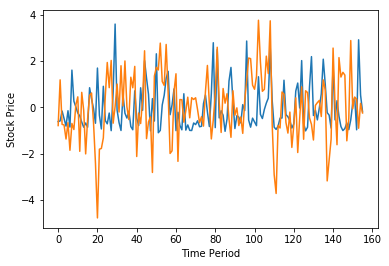

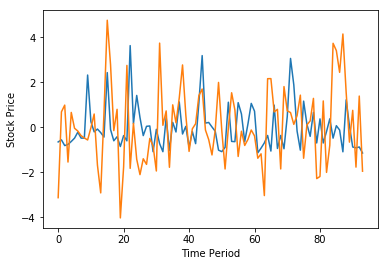

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:07:47.775565. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [52]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, seq_len, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)
print(outputs[:, -1].shape)
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)

loss = tf.reduce_sum(tf.square(Y_pred - Y))
optimizer = tf.train.AdamOptimizer(0.02)
train = optimizer.minimize(loss)

targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess :
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in range(iterations) :
        _, _ = sess.run([train, loss], feed_dict = {X:trainX,Y:trainY})
        if i % 100 == 0:
            step_loss = sess.run(loss, feed_dict = {X:valX, Y:valY}) 
            print("Step {} - loss : {}".format(i, step_loss))
        
    val_predict = sess.run(Y_pred, feed_dict = {X:valX})
    val_rmse_error = sess.run(rmse, feed_dict = {targets : valY, predictions : val_predict})
    print("VALIDATION RMSE ERROR : {}".format(val_rmse_error))
    test_predict = sess.run(Y_pred, feed_dict = {X:testX})
    test_rmse_error = sess.run(rmse, feed_dict = {targets : testY, predictions:test_predict})
    print("TEST RMSE ERROR : {}".format(test_rmse_error))
    
    plt.plot(valY)
    plt.plot(val_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

# Classification Models

# 1) Decision Tree

# Import additional packages 

In [78]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:29:48.467546. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Determin which features are used

In [79]:
# Refer to the list of columns of df_scaled to decide which features you want to use for lstm model
print(df_scaled.columns.tolist())
dt_variables = ['Average_Temperature_Normalized', 'Revenue_Normalized']

[u'Date', u'KOSPI', u'KOSDAQ', u'Average_Temperature', u'Lowest_Temperature', u'Highest_temperature', u'Precipitation', u'Average_Wind_Speed', u'Average_Relative_humidity', u'Daylight_Hours', u'Cloud_Cover', u'Duration_of_Fog', u'Revenue', u'Fitness', u'Sports_Center', u'Gym', u'Diet', u'Body', u'Busan_Sports_Center', u'Busan_Gym', 'Season', 'Average_Temperature_Normalized', 'Revenue_Normalized', 'Rate_Class']


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:29:49.961224. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Assign hyperparameters 

In [37]:
# Hyperparameters for Decision Tree model. Tune these variables.


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 16:47:19.176747. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create dataset

In [82]:
dataX = []
dataY = []
for i in range(df_scaled.shape[0] - seq_len):
    _x = df_scaled.loc[i:i+seq_len-1, dt_variables].values
    _y = df_scaled.loc[i+seq_len, ['Rate_Class']].values
    dataX.append(_x)
    dataY.append(_y)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:32:18.217021. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create train, validation and test set

In [83]:
train_size = int(len(dataY)*0.6)
val_size = int(len(dataY)*0.25)
test_size = len(dataY) - train_size - val_size

dt_trainX, dt_valX, dt_testX = np.array(dataX[:train_size]).reshape((train_size, -1)),\
                               np.array(dataX[train_size:train_size+val_size]).reshape((val_size, -1)),\
                               np.array(dataX[train_size+val_size:len(dataX)]).reshape((test_size, -1))
dt_trainY, dt_valY, dt_testY = np.array(dataY[:train_size]).reshape((train_size, -1)),\
                               np.array(dataY[train_size:train_size+val_size]).reshape((val_size, -1)),\
                               np.array(dataY[train_size+val_size:len(dataY)]).reshape((test_size, -1))

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:32:23.108049. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [84]:
print(dt_trainX)
print(dt_trainY)

[[ 2.59106621  0.39922085  0.85779789 ... -0.0450984  -0.0938004
  -0.6421524 ]
 [ 0.85779789 -0.01732845  0.68786962 ... -0.6421524   0.34801309
   0.26037108]
 [ 0.68786962  0.05209643  0.38199874 ...  0.26037108  0.58591266
  -0.36445287]
 ...
 [-0.70589988 -0.82116613 -2.4913141  ... -0.94419169 -0.03636955
   1.16546896]
 [-2.4913141   2.76176366 -2.58058482 ...  1.16546896  0.7224315
  -0.10275757]
 [-2.58058482 -0.88343833 -0.79517059 ... -0.10275757  0.99024363
  -0.01618402]]
[['moderate']
 ['low']
 ['very high']
 ['very high']
 ['high']
 ['very low']
 ['very low']
 ['moderate']
 ['moderate']
 ['moderate']
 ['low']
 ['very low']
 ['very low']
 ['very high']
 ['low']
 ['low']
 ['very low']
 ['very low']
 ['high']
 ['very low']
 ['low']
 ['very low']
 ['very high']
 ['very low']
 ['very low']
 ['very low']
 ['moderate']
 ['very high']
 ['low']
 ['very high']
 ['moderate']
 ['very low']
 ['very high']
 ['moderate']
 ['low']
 ['moderate']
 ['very high']
 ['low']
 ['very high']
 ['

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:32:25.842097. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create and train Decision Tree model

In [85]:
dt = DecisionTreeClassifier()
dt.fit(dt_trainX, dt_trainY)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:33:12.578113. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [89]:
pred_valY = dt.predict(dt_valX)
true_valY = dt_valY.reshape((-1))

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:34:26.298152. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [90]:
confusion_matrix(true_valY, pred_valY)

array([[ 0,  1,  1,  5,  6],
       [ 5, 10,  6,  6, 13],
       [ 5,  7,  6,  4,  8],
       [ 2,  8,  6,  5,  9],
       [ 6,  7, 10, 10, 10]])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:34:27.794607. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# 2) SVM

# Import additional packages 

In [78]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:29:48.467546. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Determin which features are used

In [79]:
# Refer to the list of columns of df_scaled to decide which features you want to use for lstm model
print(df_scaled.columns.tolist())
dt_variables = ['Average_Temperature_Normalized', 'Revenue_Normalized']

[u'Date', u'KOSPI', u'KOSDAQ', u'Average_Temperature', u'Lowest_Temperature', u'Highest_temperature', u'Precipitation', u'Average_Wind_Speed', u'Average_Relative_humidity', u'Daylight_Hours', u'Cloud_Cover', u'Duration_of_Fog', u'Revenue', u'Fitness', u'Sports_Center', u'Gym', u'Diet', u'Body', u'Busan_Sports_Center', u'Busan_Gym', 'Season', 'Average_Temperature_Normalized', 'Revenue_Normalized', 'Rate_Class']


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:29:49.961224. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Assign hyperparameters 

In [37]:
# Hyperparameters for Decision Tree model. Tune these variables.


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 16:47:19.176747. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create dataset

In [82]:
dataX = []
dataY = []
for i in range(df_scaled.shape[0] - seq_len):
    _x = df_scaled.loc[i:i+seq_len-1, dt_variables].values
    _y = df_scaled.loc[i+seq_len, ['Rate_Class']].values
    dataX.append(_x)
    dataY.append(_y)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:32:18.217021. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create train, validation and test set

In [83]:
train_size = int(len(dataY)*0.6)
val_size = int(len(dataY)*0.25)
test_size = len(dataY) - train_size - val_size

dt_trainX, dt_valX, dt_testX = np.array(dataX[:train_size]).reshape((train_size, -1)),\
                               np.array(dataX[train_size:train_size+val_size]).reshape((val_size, -1)),\
                               np.array(dataX[train_size+val_size:len(dataX)]).reshape((test_size, -1))
dt_trainY, dt_valY, dt_testY = np.array(dataY[:train_size]).reshape((train_size, -1)),\
                               np.array(dataY[train_size:train_size+val_size]).reshape((val_size, -1)),\
                               np.array(dataY[train_size+val_size:len(dataY)]).reshape((test_size, -1))

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:32:23.108049. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [84]:
print(dt_trainX)
print(dt_trainY)

[[ 2.59106621  0.39922085  0.85779789 ... -0.0450984  -0.0938004
  -0.6421524 ]
 [ 0.85779789 -0.01732845  0.68786962 ... -0.6421524   0.34801309
   0.26037108]
 [ 0.68786962  0.05209643  0.38199874 ...  0.26037108  0.58591266
  -0.36445287]
 ...
 [-0.70589988 -0.82116613 -2.4913141  ... -0.94419169 -0.03636955
   1.16546896]
 [-2.4913141   2.76176366 -2.58058482 ...  1.16546896  0.7224315
  -0.10275757]
 [-2.58058482 -0.88343833 -0.79517059 ... -0.10275757  0.99024363
  -0.01618402]]
[['moderate']
 ['low']
 ['very high']
 ['very high']
 ['high']
 ['very low']
 ['very low']
 ['moderate']
 ['moderate']
 ['moderate']
 ['low']
 ['very low']
 ['very low']
 ['very high']
 ['low']
 ['low']
 ['very low']
 ['very low']
 ['high']
 ['very low']
 ['low']
 ['very low']
 ['very high']
 ['very low']
 ['very low']
 ['very low']
 ['moderate']
 ['very high']
 ['low']
 ['very high']
 ['moderate']
 ['very low']
 ['very high']
 ['moderate']
 ['low']
 ['moderate']
 ['very high']
 ['low']
 ['very high']
 ['

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:32:25.842097. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create and train Decision Tree model

In [85]:
dt = DecisionTreeClassifier()
dt.fit(dt_trainX, dt_trainY)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:33:12.578113. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [89]:
pred_valY = dt.predict(dt_valX)
true_valY = dt_valY.reshape((-1))

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:34:26.298152. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [90]:
confusion_matrix(true_valY, pred_valY)

array([[ 0,  1,  1,  5,  6],
       [ 5, 10,  6,  6, 13],
       [ 5,  7,  6,  4,  8],
       [ 2,  8,  6,  5,  9],
       [ 6,  7, 10, 10, 10]])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-04 17:34:27.794607. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)
